# Data Story Telling

# 1. Introduction

This notebook is part of the data story telling module. The purpose of this notebook is to explore the data extracted from:
- 00_Data_Wrangling-Weather.ipynb
- 01_Data_Wrangling_Boston.ipynb
- 02a_Data_Wrangling_Potholes.ipynb
- 02b_Google_Geo_API_Fetcher.ipynb

The corresponding data files are strored in the following folders:
- *./Original Data*
- *./Intermediate Data*
- *./Cleaned Data*

The methodology used to cleaned the files is described in the **Data Wrangling Repord** (*./Data Wrangling Report.pdf*)

Through this notebook, the following questions will be investigated:
1. Are repairs faster/slower in certain neighborhood?
2. How does the weather impact the number of claims?
3. How does the weather impact the repair time?


## 1.1. Library

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import folium

import datetime

## 1.2. Load data sets

In [2]:
potholes_df = pd.read_csv('./Cleaned Data/Closed_Pothole_Cases_Cleaned.csv',
                          parse_dates=['CLOSED_DT','OPEN_DT','TARGET_DT'],
                          index_col=0)
weather_df = pd.read_csv('./Cleaned Data/Weather_Data_Cleaned.csv',index_col='DATE',parse_dates=True)
boston_zip_df = pd.read_csv('./Cleaned Data/Boston_Pop_Cleaned.csv',index_col='zipcode')

Confirm that the import was successful:

In [3]:
# Display df shapes
print(potholes_df.shape)
print(weather_df.shape)
print(boston_zip_df.shape)

(35434, 27)
(211, 21)
(30, 6)


In [4]:
# Display df structures
print(potholes_df.info())
print('----------------------')
print(weather_df.info())
print('----------------------')
print(boston_zip_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35434 entries, 0 to 14251
Data columns (total 27 columns):
CASE_ENQUIRY_ID                   35434 non-null int64
CASE_STATUS                       35434 non-null object
CASE_TITLE                        35434 non-null object
CLOSED_DT                         35434 non-null datetime64[ns]
CLOSURE_REASON                    35434 non-null object
ClosedPhoto_Bool                  35434 non-null bool
LATITUDE                          35434 non-null float64
LOCATION_STREET_NAME              35434 non-null object
LOCATION_ZIPCODE                  35434 non-null float64
LONGITUDE                         35434 non-null float64
Location                          35434 non-null object
OPEN_DT                           35434 non-null datetime64[ns]
OnTime_Status                     35433 non-null object
OnTime_Status_Bool                35434 non-null bool
QUEUE                             35434 non-null object
Source                            354

# 2. Claim evolution over the years

## 2.1. Claim per seasons

In order to get a sense of the efficiency of the Departement of Transportation, we are going to investigate the evolution of the number of claims over the years. 

In [5]:
# Prepare dataframe
yearly_claim_df = potholes_df[['OPEN_DT','CASE_ENQUIRY_ID']].copy()
yearly_claim_df.OPEN_DT = yearly_claim_df.OPEN_DT.apply(lambda x: x.replace(day=(x.day//16*15+1))).dt.date

# Add season for visual inspection
season_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall',
    11: 'Winter',
    12: 'Winter',
}

yearly_claim_df = yearly_claim_df.groupby('OPEN_DT').count()

yearly_claim_df['Season'] = yearly_claim_df.index.map(lambda x: season_dict[x.month])
yearly_claim_df.head()

,CASE_ENQUIRY_ID,Season
OPEN_DT,,
2011-07-01,117,Summer
2011-07-16,66,Summer
2011-08-01,82,Fall
2011-08-16,96,Fall
2011-09-01,68,Fall


In [6]:
yearly_claim_season_df = yearly_claim_df.groupby('Season').sum()
yearly_claim_season_df

,CASE_ENQUIRY_ID
Season,
Fall,3902
Spring,16505
Summer,7766
Winter,7261


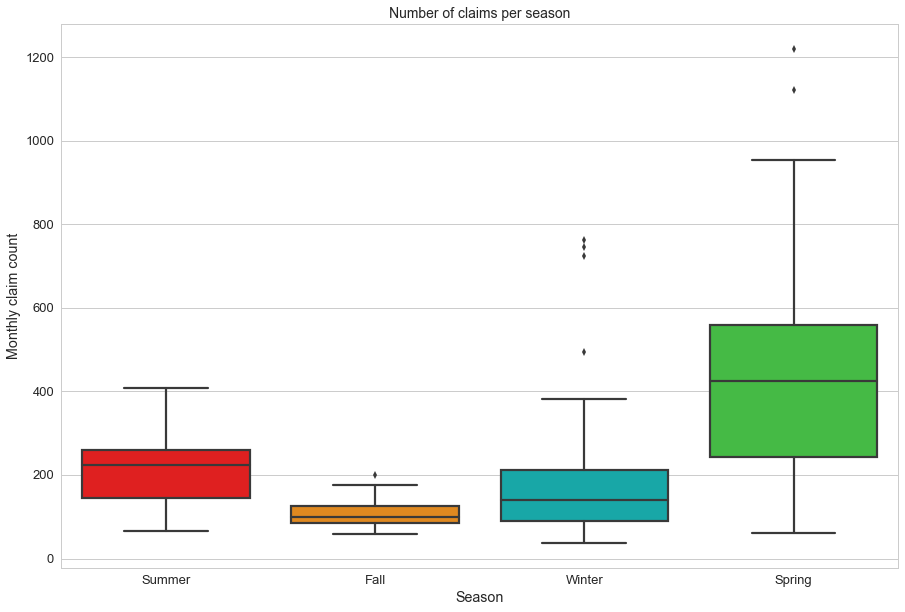

In [7]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='Season',y="CASE_ENQUIRY_ID",
            data=yearly_claim_df,
            palette = sns.color_palette(['red','darkorange','c','limegreen']))
ax.set(xlabel="Season",ylabel='Monthly claim count')
plt.title('Number of claims per season', fontsize=14);

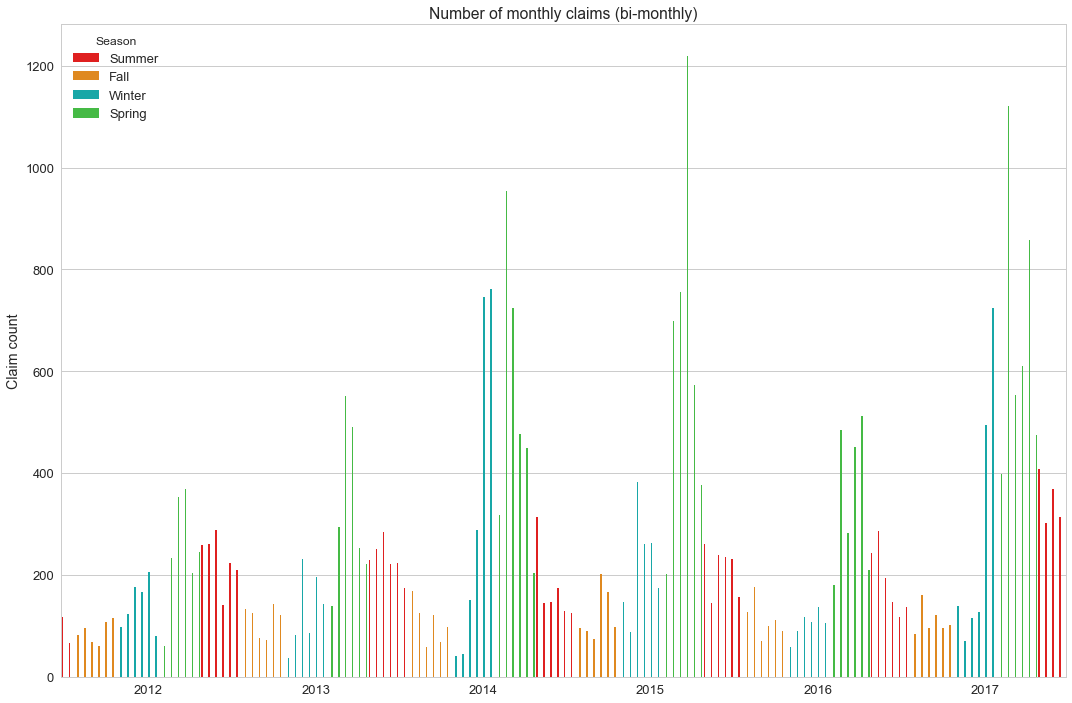

In [8]:
# Set main plot parameters
sns.set_style("whitegrid")

# Create x labels using list comprehension
x_tick = [x.year if x.day==1 and x.month==1 else '' for x in yearly_claim_df.index.values]

# Plot
fig, ax = plt.subplots(figsize=(18,12))
ax = sns.barplot(x=yearly_claim_df.index,
                 y=yearly_claim_df.CASE_ENQUIRY_ID,hue=yearly_claim_df.Season,
                 palette = sns.color_palette(['red','darkorange','c','limegreen']))

# Set plot labels
ax.set_title("Number of monthly claims (bi-monthly)")
ax.set(xlabel="",ylabel='Claim count')
ax.set_xticklabels(x_tick)

plt.show()

As expected, a lot more potholes appears during the cold weather. From the above plot, we can make two conclusions:
 1. The claim number peaks during the spring. This lag is due to the time it takes for the potholes to form. Indeed, in order to form, a pothole needs to freeze and unfreeze multiple times. The lag can be estimated to 1 to 2 months.
 2. The pothole appearance is directly proportional to the snow amount and temperature. Both 2014 and 2015 winters were famous for the amount of snow that fell in the region while the winter of 2016 was a lot warmer.
 
 In order to validate the second claim, we will use the plot above and we will superimpose the snowfall and temperature variation.

## 2.2. Temperature and snow/rain effects on the number of claims

In [9]:
# Prepare dataframe
yearly_claim_offset_df = potholes_df[['OPEN_DT','CASE_ENQUIRY_ID']].copy()
yearly_claim_offset_df.OPEN_DT = yearly_claim_offset_df.OPEN_DT.apply(lambda x: x.replace(day=1)).dt.date

# Add season for visual inspection
season_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall',
    11: 'Winter',
    12: 'Winter',
}

# We create the season feature
yearly_claim_offset_df = yearly_claim_offset_df.groupby('OPEN_DT').count()
yearly_claim_offset_df['Season'] = yearly_claim_offset_df.index.map(lambda x: season_dict[x.month])

# Weather data
offset = 1 
weather_offset_df = weather_df.loc[:,['DSNW','DT32','TAVG',"DP10"]]
# We include a one month offset (set after trial and error)
weather_offset_df.index = weather_offset_df.index+pd.tseries.offsets.DateOffset(months=1)
weather_offset_df.index

# Merge pothole and weather data
yearly_claim_offset_df = yearly_claim_offset_df.merge(right=weather_offset_df,how='left',left_index=True,right_index=True)
yearly_claim_offset_df.tail()

,CASE_ENQUIRY_ID,Season,DSNW,DT32,TAVG,DP10
OPEN_DT,,,,,,
2017-02-01,1520,Spring,2,18,35.1,8
2017-03-01,1164,Spring,6,20,36.7,6
2017-04-01,1331,Spring,2,21,34.1,5
2017-05-01,711,Summer,1,0,51.7,6
2017-06-01,683,Summer,0,0,56.3,7


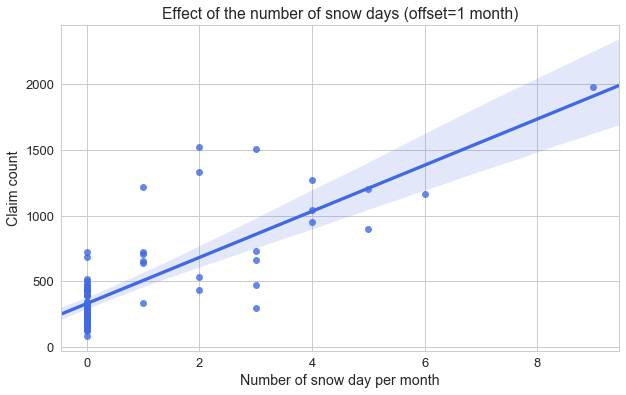

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='DSNW',y="CASE_ENQUIRY_ID",data=yearly_claim_offset_df,color="royalblue")
ax.set_title("Effect of the number of snow days (offset=1 month)")
ax.set(xlabel="Number of snow day per month",ylabel='Claim count');

**Note**  
As expected, there is a clear correlation between the frequency of snowfall over a month and the number of claim created the next month.

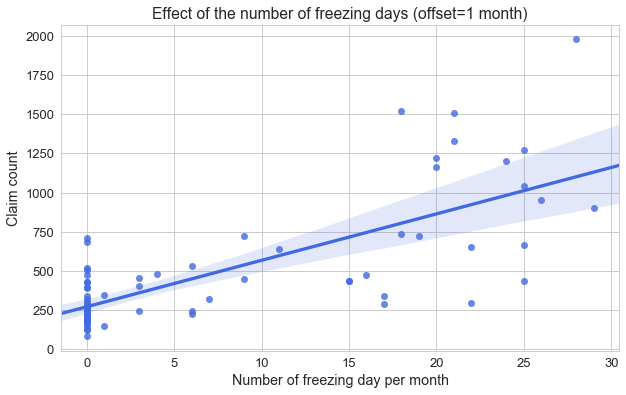

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='DT32',y="CASE_ENQUIRY_ID",data=yearly_claim_offset_df,color="royalblue")
ax.set_title("Effect of the number of freezing days (offset=1 month)")
ax.set(xlabel="Number of freezing day per month",ylabel='Claim count');

**Note**  
As expected, there is a clear correlation between the frequency of freezing days over a month and the number of claim created the next month. However, we have to be careful because the number of snow day is also correlated with the number of freezing days (See plot below).

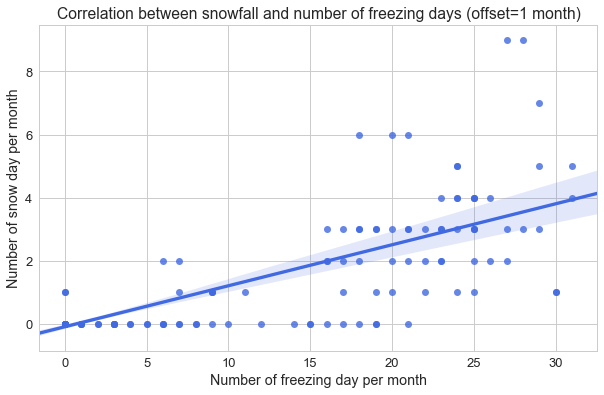

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='DT32',y="DSNW",data=weather_df,color="royalblue")
ax.set_title("Correlation between snowfall and number of freezing days (offset=1 month)")
ax.set(xlabel="Number of freezing day per month",ylabel='Number of snow day per month');

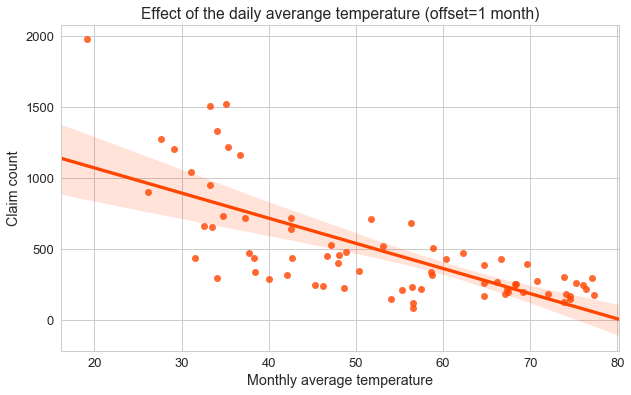

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='TAVG',y="CASE_ENQUIRY_ID",data=yearly_claim_offset_df,color="orangered")
ax.set_title("Effect of the daily averange temperature (offset=1 month)")
ax.set(xlabel="Monthly average temperature",ylabel='Claim count');

**Note**  
As expected, there is a clear correlation between the average monthly temperature and the number of claim created the next month.

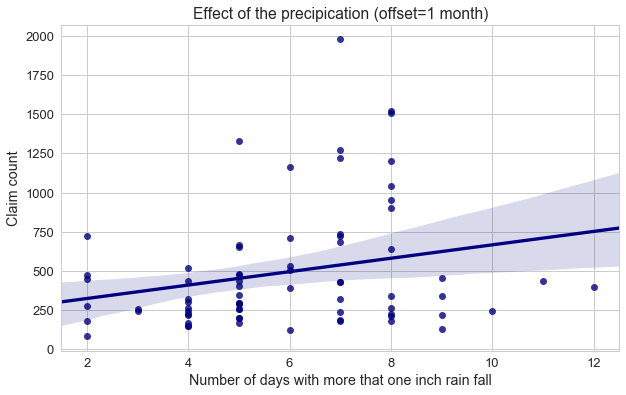

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='DP10',y="CASE_ENQUIRY_ID",data=yearly_claim_offset_df,color="navy")
ax.set_title("Effect of the precipication (offset=1 month)")
ax.set(xlabel="Number of days with more that one inch rain fall",ylabel='Claim count');

**Note**  
The correleation between precipitation and claims is not really obvious.

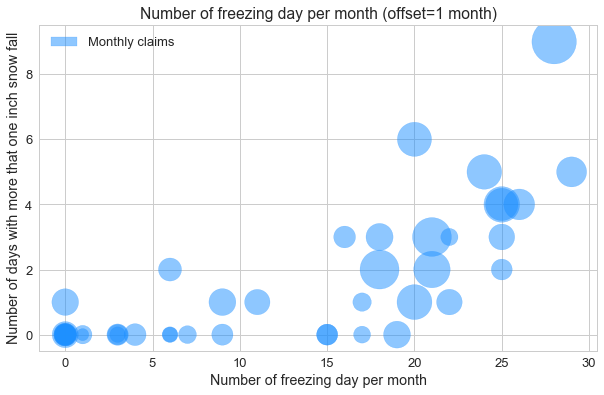

In [15]:
# Scatter plot of the monthly number of claims as a function of the snowfall and freezing days
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(x=yearly_claim_offset_df['DT32'],
            y=yearly_claim_offset_df['DSNW'],
            s=yearly_claim_offset_df['CASE_ENQUIRY_ID'],
            c = 'dodgerblue',alpha = 0.5)
ax.set_title("Number of freezing day per month (offset=1 month)")
ax.set(xlabel="Number of freezing day per month",ylabel='Number of days with more that one inch snow fall');

plt.legend(handles=[mpatches.Patch(color='dodgerblue', alpha=0.5,label='Monthly claims')])

## 2.3. Variation of the repair delay over the year

Now that we know the cold weather has a significant impact on the road damage frequency, we will be looking at the impact of the weather on the repair time. The repair time is defined as the difference between the claim closure date and the claim creation date. As previously stated, the pothole database can be modified by making a request to 311 or by city workers. A significant number of potholes are discovered and fixed at the same time by city workers patrolling in the street. In order to only focus on claim made by "normal" users, we will restrain the data set to potholes that took more than half a day to be fixed.

In [16]:
# Prepare dataframe
yearly_repair_time_df = potholes_df[['OPEN_DT','time_repair']].copy()
yearly_repair_time_df = yearly_repair_time_df[yearly_repair_time_df.time_repair>=0.5]

# Re-adjust the OPEN_DT to either the first day of the month or the 15th (for plotting purpose)
yearly_repair_time_df.OPEN_DT = yearly_repair_time_df.OPEN_DT.apply(lambda x: x.replace(day=(x.day//16*15+1))).dt.date

# Add season for visual inspection
season_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall',
    11: 'Winter',
    12: 'Winter',
}

yearly_repair_time_df = yearly_repair_time_df.groupby('OPEN_DT').median()

yearly_repair_time_df['Season'] = yearly_repair_time_df.index.map(lambda x: season_dict[x.month])
yearly_repair_time_df.head()

,time_repair,Season
OPEN_DT,,
2011-07-01,1.303767,Summer
2011-07-16,1.880324,Summer
2011-08-01,1.040729,Fall
2011-08-16,2.024595,Fall
2011-09-01,1.230961,Fall


In [18]:
yearly_repair_time_df.groupby('Season').median()

,time_repair
Season,
Fall,1.179855
Spring,1.199578
Summer,1.103079
Winter,1.109936


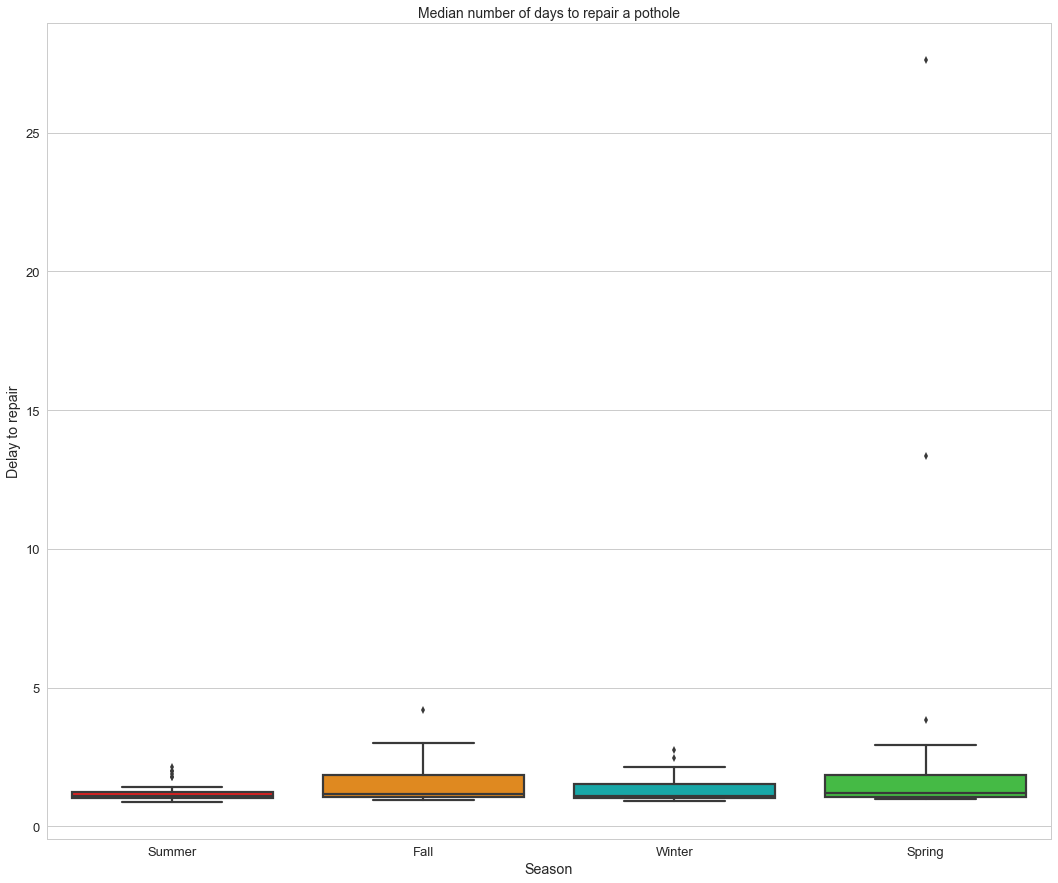

In [22]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})
fig, ax = plt.subplots(figsize=(18,15))
sns.boxplot(x='Season',y="time_repair",
            data=yearly_repair_time_df,
            palette = sns.color_palette(['red','darkorange','c','limegreen']))
ax.set(xlabel="Season",ylabel='Delay to repair')
plt.title('Median number of days to repair a pothole', fontsize=14);

With only a few outliers and an median time of 2 days to fix a pothole, the city has a good response time.

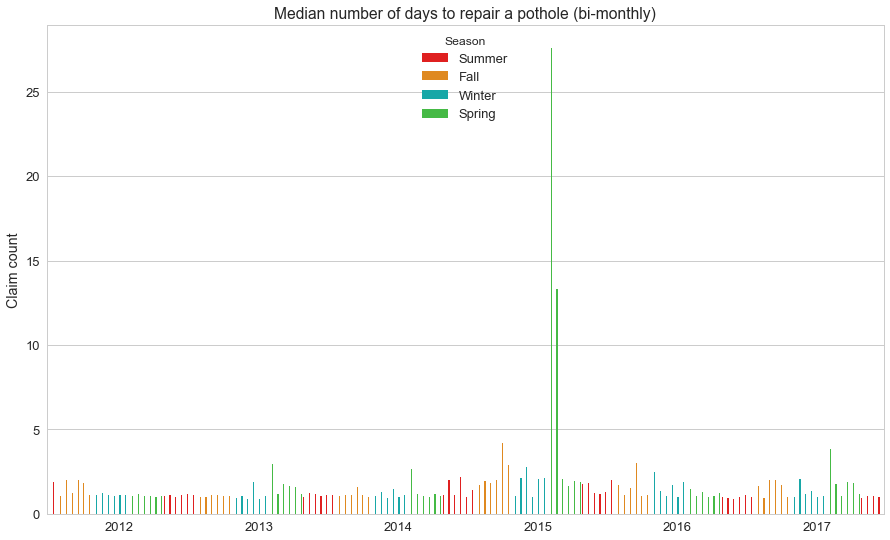

In [23]:
# Set main plot parameters
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})

# Create x labels using list comprehension
x_tick = [x.year if x.day==1 and x.month==1 else '' for x in yearly_claim_df.index.values]

# Plot
fig, ax = plt.subplots(figsize=(15,9))
ax = sns.barplot(x=yearly_repair_time_df.index,
            y=yearly_repair_time_df.time_repair,hue=yearly_claim_df.Season,
           palette = sns.color_palette(['red','darkorange','c','limegreen']))

# Set plot labels
ax.set_title("Median number of days to repair a pothole (bi-monthly)")
ax.set(xlabel="",ylabel='Claim count')
ax.set_xticklabels(x_tick)

plt.show()

Obviously, the first month of the spring of 2015 is an oulier. Let's investigate why the time to repair was so high. But the main reason was the weather. Indeed, New England experienced the worst winter in decades. The accumulation of snow, the long lasting freezing temperatures prevented the city to fix the potholes.

In [26]:
claims_feb_2015_df=potholes_df[(potholes_df.OPEN_DT>datetime.date(2015,2,1)) & (potholes_df.OPEN_DT<datetime.date(2015,3,1)) & (potholes_df.time_repair>0.5)]

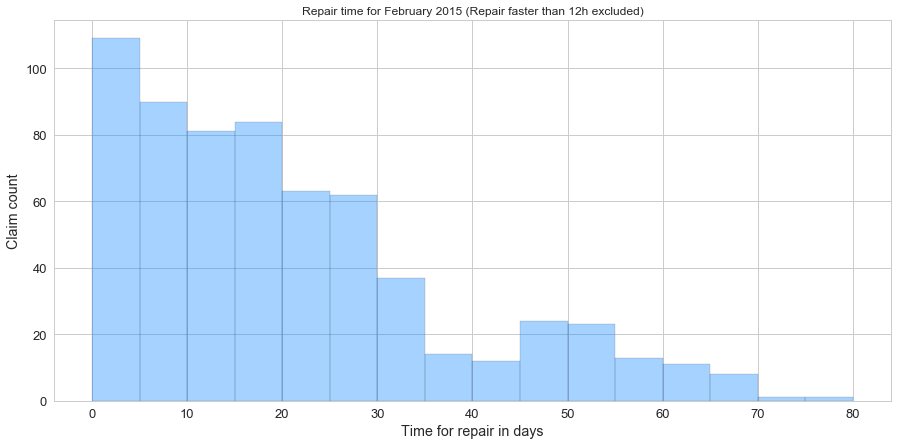

In [25]:
# Set main plot parameters
fig, ax = plt.subplots(figsize=(15,7))
sns.set_style("whitegrid")

sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.distplot(claims_feb_2015_df.time_repair,
             kde=False,hist_kws=dict(edgecolor="black"),color='dodgerblue',
            bins = np.linspace(0, 80, 17))

# Set plot labels
ax.set_title("Repair time for February 2015 (Repair faster than 12h excluded)")
ax.set(xlabel="Time for repair in days",ylabel='Claim count');

As shown above, the distribution of the repair time over the month of February 2015 is well distributed.

Just like we did for the monthly number of claims, we will evaluate the impact of the weather on the repair delay.

## 2.4 Temperature and snow/rain effects on the repair time

In [27]:
# Prepare dataframe
yearly_repair_time_df = potholes_df[['OPEN_DT','time_repair','CASE_ENQUIRY_ID']].copy()
yearly_repair_time_df = yearly_repair_time_df[yearly_repair_time_df.time_repair>=0.5]
yearly_repair_time_df.OPEN_DT = yearly_repair_time_df.OPEN_DT.apply(lambda x: x.replace(day=1)).dt.date

# Filter the month of february 2015
yearly_repair_time_df = yearly_repair_time_df[yearly_repair_time_df.OPEN_DT!=datetime.date(2015,2,1)]

# Add season for visual inspection
season_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall',
    11: 'Winter',
    12: 'Winter',
}

# We create the season feature
yearly_repair_time_df['Season'] = yearly_repair_time_df.OPEN_DT.map(lambda x: season_dict[x.month])
yearly_repair_time_df = yearly_repair_time_df.groupby('OPEN_DT').median()

# Weather data
weather_repair_df = weather_df.loc[:,['DSNW','DT32','TAVG',"DP10"]]

# Merge pothole and weather data
yearly_repair_time_df = yearly_repair_time_df.merge(right=weather_repair_df,how='left',left_index=True,right_index=True)
yearly_repair_time_df.tail()

,time_repair,CASE_ENQUIRY_ID,DSNW,DT32,TAVG,DP10
OPEN_DT,,,,,,
2017-02-01,1.983466,1.010020e+11,6,20,36.7,6
2017-03-01,1.751892,1.010020e+11,2,21,34.1,5
2017-04-01,1.789896,1.010021e+11,1,0,51.7,6
2017-05-01,0.994479,1.010021e+11,0,0,56.3,7
2017-06-01,1.005943,1.010021e+11,0,0,69.5,7


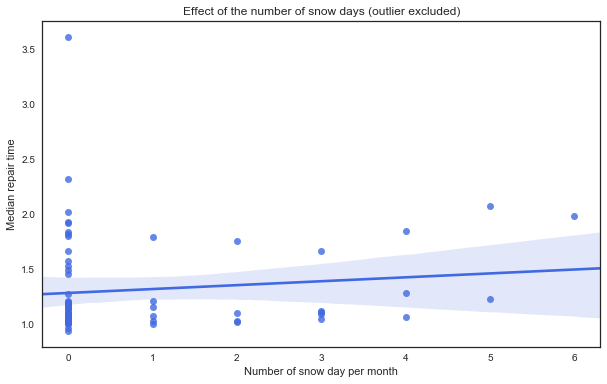

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='DSNW',y="time_repair",data=yearly_repair_time_df,color="royalblue")
ax.set_title("Effect of the number of snow days (outlier excluded)")
ax.set(xlabel="Number of snow day per month",ylabel='Median repair time');

There is no clear correlation between the number of snow day and the time to repair a pothole.

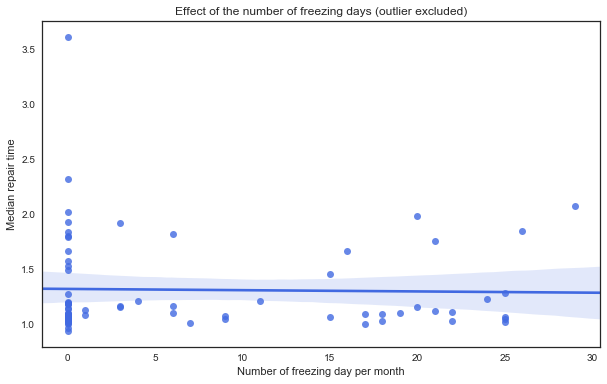

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='DT32',y="time_repair",data=yearly_repair_time_df,color="royalblue")
ax.set_title("Effect of the number of freezing days (outlier excluded)")
ax.set(xlabel="Number of freezing day per month",ylabel='Median repair time');

There is no clear correlation between the number of freezing day and the time to repair a pothole.

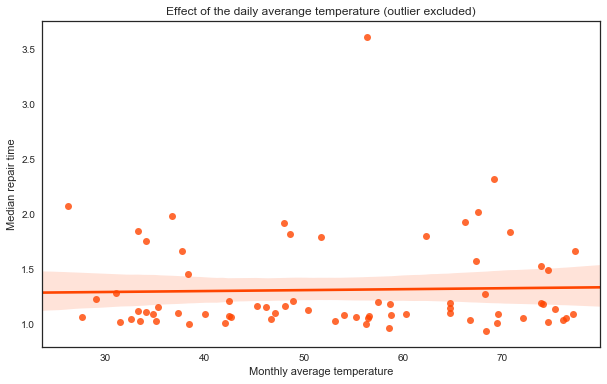

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='TAVG',y="time_repair",data=yearly_repair_time_df,color="orangered")
ax.set_title("Effect of the daily averange temperature (outlier excluded)")
ax.set(xlabel="Monthly average temperature",ylabel='Median repair time');

There is no clear correlation between the averege temperature and the time to repair a pothole.

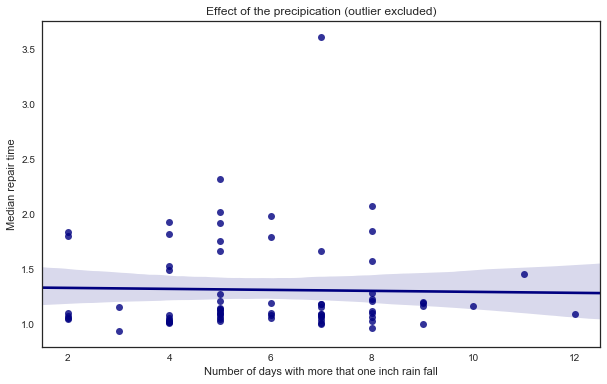

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='DP10',y="time_repair",data=yearly_repair_time_df,color="navy")
ax.set_title("Effect of the precipication (outlier excluded)")
ax.set(xlabel="Number of days with more that one inch rain fall",ylabel='Median repair time');

There is no clear correlation between the number of rainy day and the time to repair a pothole.

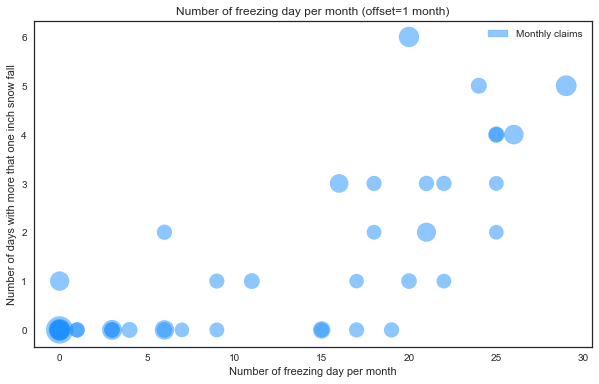

In [32]:
# Scatter plot of the monthly number of claims as a function of the snowfall and freezing days
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(x=yearly_repair_time_df['DT32'],
            y=yearly_repair_time_df['DSNW'],
            s=yearly_repair_time_df['time_repair']*200,
            c = 'dodgerblue',alpha = 0.5)
ax.set_title("Number of freezing day per month (offset=1 month)")
ax.set(xlabel="Number of freezing day per month",ylabel='Number of days with more that one inch snow fall');

plt.legend(handles=[mpatches.Patch(color='dodgerblue', alpha=0.5,label='Monthly claims')])

Again, there is no clear correlation. In conlusion, it seems that the repair time is not impacted by the weather conditions.

# Number of claims vs. time for repair

In this section, we will investigate if the time to repair a pothole and the number of claim are correlater. We will be working by monthly period.

In [37]:
# Prepare dataframe
repair_vs_count_df = potholes_df[['OPEN_DT','time_repair','CASE_ENQUIRY_ID']].copy()
repair_vs_count_df = repair_vs_count_df[repair_vs_count_df.time_repair>=0.5]

# Re-adjust the OPEN_DT to the first day of the month
repair_vs_count_df.OPEN_DT = repair_vs_count_df.OPEN_DT.apply(lambda x: x.replace(day=1)).dt.date

repair_vs_count_df = repair_vs_count_df.groupby('OPEN_DT').agg({'time_repair':['median'], 'CASE_ENQUIRY_ID':['count']})

repair_vs_count_df.head()

,time_repair,CASE_ENQUIRY_ID
,median,count
OPEN_DT,,
2011-07-01,1.660625,147
2011-08-01,1.192743,140
2011-09-01,1.567940,98
2011-10-01,1.194236,169
2011-11-01,1.123142,160


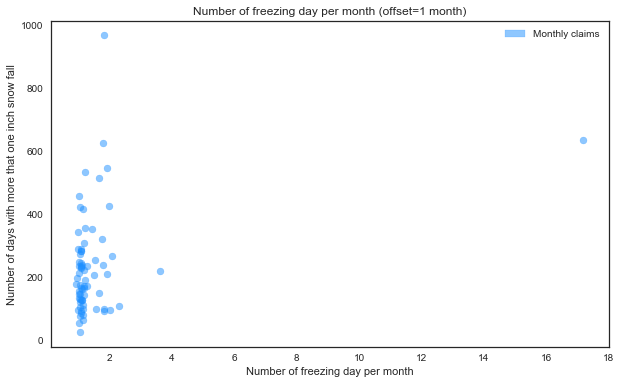

In [38]:
# Scatter plot of the monthly number of claims as a function of the snowfall and freezing days
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(x=repair_vs_count_df['time_repair'],
            y=repair_vs_count_df['CASE_ENQUIRY_ID'],
            c = 'dodgerblue',alpha = 0.5)
ax.set_title("Number of freezing day per month (offset=1 month)")
ax.set(xlabel="Number of freezing day per month",ylabel='Number of days with more that one inch snow fall');

plt.legend(handles=[mpatches.Patch(color='dodgerblue', alpha=0.5,label='Monthly claims')])

# 2. Intersections 

In [33]:
# Prepare dataframe
intersection_df = potholes_df[['CASE_ENQUIRY_ID','is_intersection']].copy()

In [34]:
intersection_df = intersection_df.groupby('is_intersection').count()
intersection_df

,CASE_ENQUIRY_ID
is_intersection,
False,23344
True,12090


As shown above, the number of potholes located within intersection is extremely high compare to the proportion of road that constitute intersections. This can be explains by the failure mechanism of the top layer of the road. Indeed the asphalt works well in compression but is not as good to support shear loads which happen when a car changes direction.  
If we conservatively assume that intersection account for 10% of the roads in the city, while they account for ~33% of the pothole claims.

# 3. Claim distristribution per neighborhood

In this section, we will try to understand if more potholes claimed are reported in certain neighborhoods. We will normalized the data by dividing the number of claim by 100 inhabitants.

In [27]:
# Create a data frame that contains the number of claim per year per zip code
#potholes_df.LOCATION_ZIPCODE=potholes_df.LOCATION_ZIPCODE.astype(int)
#yearly_claim_per_zip_df = potholes_df[['CASE_ENQUIRY_ID','LOCATION_ZIPCODE']].groupby([potholes_df['OPEN_DT'].map(lambda x: x.year),'LOCATION_ZIPCODE']).count()

# Prepare the data frame for join
#yearly_claim_per_zip_df.reset_index(level=[0,1],inplace=True)

#yearly_claim_per_zip_df.head()

In [28]:
#yearly_claim_per_zip_df = yearly_claim_per_zip_df.merge(boston_zip_df,
#                                                        left_on='LOCATION_ZIPCODE',
#                                                        right_index=True,
#                                                        how='left')
#yearly_claim_per_zip_df.head()